In [1]:
import torch
import torch.nn as nn
import numpy as np
import warnings
import IPython.display
import io
from PIL import Image
from einops import rearrange
from datasets import load_dataset
from torchvision.transforms import (
    RandomResizedCrop, Resize, Grayscale,
    PILToTensor, ToPILImage, 
    Compose, RandomHorizontalFlip )
from DenseViT import DenseViT
from fastprogress.fastprogress import master_bar, progress_bar
class Config: pass

In [2]:
device = "cuda:3"

config = Config()
# Training and optimizer config
config.batch_size = 128
config.grad_accum_steps = 1
config.min_lr = 1e-6
config.max_lr = 1e-4 
config.warmup_steps = 10000
config.plot_update = 128
config.patience = 128
config.weight_decay = 0.
config.epochs = 30
config.num_workers = 12
config.valid_samples_per_epoch = 256

# Colorization model config
config.image_size = 128
config.channels = 3
config.patch_size = 8
config.num_classes = 192
config.embed_dim = 192
config.depth = 12
config.heads = 3
config.mlp_dim = 768
config.dim_head = config.embed_dim//config.heads

In [3]:
model = DenseViT(
    image_size = config.image_size,
    channels = config.channels,
    patch_size = config.patch_size,
    num_classes = config.num_classes,
    dim = config.embed_dim,
    depth = config.depth,
    heads = config.heads,
    mlp_dim = config.mlp_dim,
    dim_head = config.dim_head
).to(device)
sum(p.numel() for p in model.parameters())/1e6

5.405184

In [4]:
dataset_train = load_dataset('imagenet-1k',split='train',trust_remote_code=True)
dataset_valid = load_dataset('imagenet-1k',split='validation',trust_remote_code=True)

Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

In [5]:
L = config.image_size
C = config.channels

train_transform = Compose([
    RandomResizedCrop(
        size=(L,L),
        scale=(0.5, 1),
        interpolation=Image.Resampling.LANCZOS
    ),
    RandomHorizontalFlip(0.5),
    PILToTensor()
])

valid_transform = Compose([
    Resize(
        size=(L,L),
        interpolation=Image.Resampling.LANCZOS
    ),
    PILToTensor(),
])

def train_collate_fn(batch):
    B = len(batch)    
    x = torch.zeros( (B, C, L, L), dtype=torch.uint8)
    y = torch.zeros( (B, C, L, L), dtype=torch.uint8)

    for i_sample, sample in enumerate(batch):
        img = sample['image'].convert("RGB")
        y[i_sample,:,:,:] = train_transform(img)
        x[i_sample,:,:,:] = Grayscale(num_output_channels=3)(y[i_sample,:,:,:])
    return x, y

def valid_collate_fn(batch):
    B = len(batch)    
    x = torch.zeros( (B, C, L, L), dtype=torch.uint8)
    y = []
    for i_sample, sample in enumerate(batch):
        img = sample['image'].convert("RGB")
        x[i_sample,:,:,:] = Grayscale(num_output_channels=3)(valid_transform(img))
        y.append(img)
    return x, y

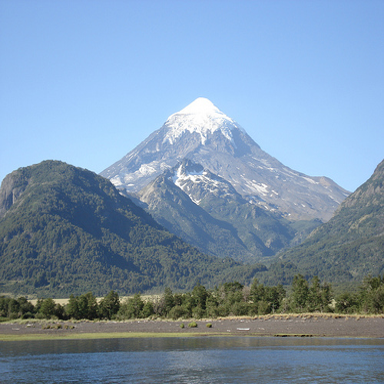

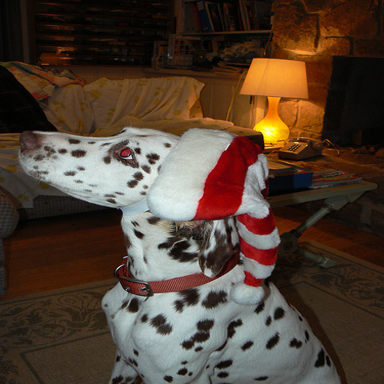

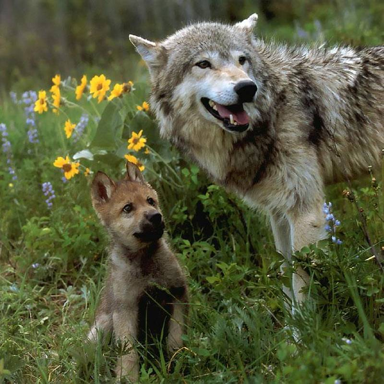

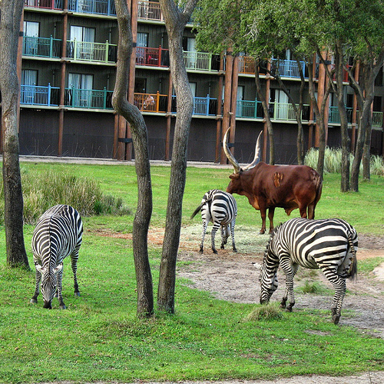

In [6]:
 display_samples = torch.utils.data.DataLoader(
    dataset_valid.select([2,36,46,83]),
    batch_size=4,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=valid_collate_fn
)
valid_x, valid_y = next(iter(display_samples))
valid_x = valid_x.to(torch.float)
valid_x = valid_x / 255
valid_x = valid_x.to(device)
for vy in valid_y:
    display(vy.resize((384,384)))

In [7]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay
)

def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-3,
    min_lr=config.min_lr
)

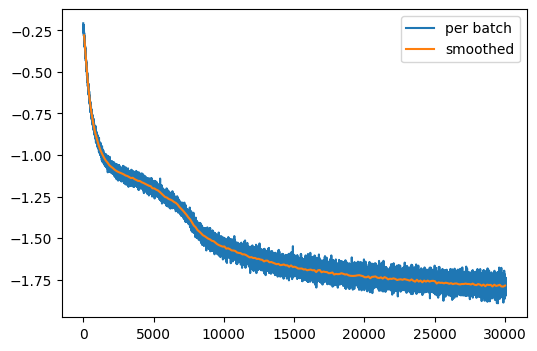

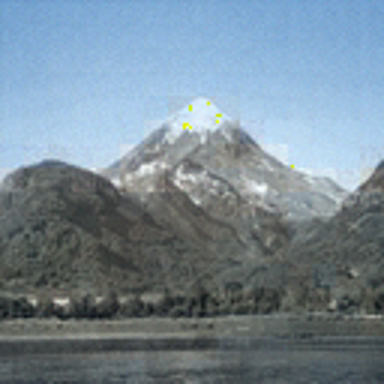

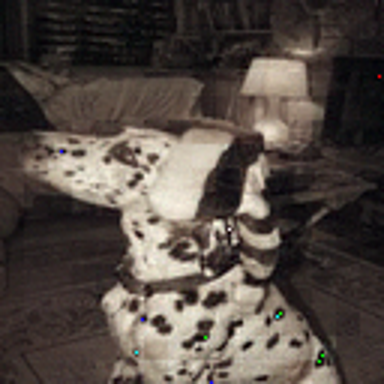

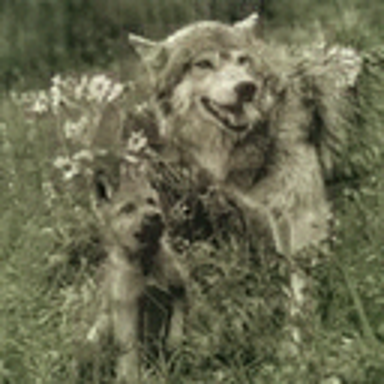

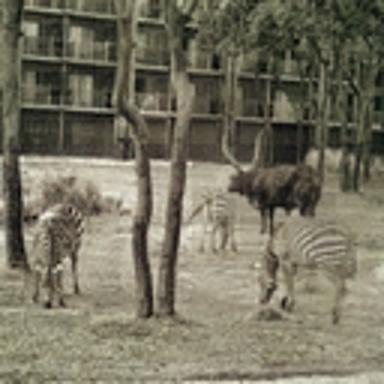

In [ ]:
warnings.filterwarnings("ignore", message="Corrupt EXIF data.  Expecting to read .* bytes but only got .*", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Metadata Warning, tag .* had too many entries: .* expected .*", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning, module="PIL.TiffImagePlugin")

mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
img_displays = []
train_loss = []
valid_loss = []
learning_rates = [optimizer.param_groups[0]['lr']]

i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        x = x.to(torch.float)
        y = y.to(torch.float)
        x = x / 255
        y = y / 255
        x = x.to(device)
        y = y.to(device)

        loss = nn.functional.mse_loss(model(x), y)
        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting
        if len(train_loss) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])
            
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # Display selected images
            model.eval()
            with torch.no_grad():
                pred = model(valid_x)
            model.train()
            for img_idx, img in enumerate(pred):
                buffer = io.BytesIO()
                ToPILImage()(img).resize((384,384)).save(buffer, format="PNG")
                buffer.seek(0)
                if len(img_displays) <= img_idx:
                    img_displays.append(display(IPython.display.Image(buffer.read()), display_id=True))
                else:
                    IPython.display.update_display(IPython.display.Image(buffer.read()), display_id=img_displays[img_idx].display_id)

        i_step+=1
        
    # validation
    model.eval()
    valid_loss.append(0)
    rand_sample = torch.randint(low=0, high=dataset_valid.num_rows,size=(config.valid_samples_per_epoch,))
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid.select(rand_sample),
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    valid_loss_per_sample = []
    for i_batch, (x,y) in enumerate(pb_valid):
        x = x.to(torch.float)
        x = x / 255
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            for i_valid, yi in enumerate(y):
                pred_i = Resize(size=(yi.height, yi.width))(pred[i_valid])
                yi = PILToTensor()(yi)
                yi = yi.to(torch.float)
                yi = yi / 255
                yi = yi.to(device)
                loss = nn.functional.mse_loss(pred_i, yi)
                valid_loss_per_sample.append(loss.item())
    valid_loss[-1] = np.median(valid_loss_per_sample)
    mb.main_bar.comment = f'valid_loss {valid_loss[-1]:.4g}'
    mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

    torch.save({
        'i_epoch': i_epoch,
        'model_state_dict': model.state_dict(),
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_loss': valid_loss,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")